In [43]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set the display option to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_folder = '/content/drive/MyDrive/Dataset/data'
step_data_frames = []

# Loop through the data folder and its subfolders
for root, dirs, files in os.walk(data_folder):
    for filename in files:
        # Check if the file is a .csv file
        if filename.endswith('.csv'):
            csv_path = os.path.join(root, filename)
            step_mixed_path = os.path.join(root, filename.replace("Clipped", "") + '.stepMixed')

            # Check if the corresponding .csv.stepMixed file exists
            if os.path.exists(step_mixed_path):
                # Read the .csv file
                step_data = pd.read_csv(csv_path, usecols=[1, 2, 3, 4, 5, 6])
                step_data = step_data.dropna()  # Removes missing values

                # Reads StepIndices value - Start and End index of a step
                col_names = ['start_index', 'end_index']
                step_indices = pd.read_csv(step_mixed_path, names=col_names)

                # Removing missing values and outliers
                step_indices = step_indices.dropna()
                step_indices = step_indices.loc[(step_indices.end_index < step_data.shape[0])]

                # Create a labels column and initialize with default value
                step_data["Label"] = "No Label"

                # Assign "start" and "end" labels to corresponding rows
                for index, row in step_indices.iterrows():
                    step_data.loc[row['start_index'], "Label"] = "start"
                    step_data.loc[row['end_index'], "Label"] = "end"

                # Append the DataFrame to the list
                step_data_frames.append(step_data)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(step_data_frames, ignore_index=True)
print(combined_df.shape)
test_path = os.path.join(data_folder, "testdata.csv")
test_df = pd.read_csv(test_path)

(722582, 7)


pd.set_option('display.max_columns', None) - This line sets the maximum number of columns to be displayed in pandas DataFrame to None, which means all columns will be displayed.
pd.set_option('display.max_rows', None) - This line sets the maximum number of rows to be displayed in pandas DataFrame to None, which means all rows will be displayed.

The following lines initiate a loop that iterates through all files in the data_folder and its subfolders using os.walk:
for root, dirs, files in os.walk(data_folder):

If the file is a .csv file, it constructs the path to the CSV file and the corresponding .csv.stepMixed file:
csv_path = os.path.join(root, filename)
step_mixed_path = os.path.join(root, filename.replace("Clipped", "") + '.stepMixed')

It then checks if the .csv.stepMixed file exists for the current .csv file:
if os.path.exists(step_mixed_path):

If the .csv.stepMixed file exists, it reads the .csv file using pd.read_csv and selects specific columns for reading using the usecols parameter:
step_data = pd.read_csv(csv_path, usecols=[1, 2, 3, 4, 5, 6])

The next line removes any rows with missing values (NaN) from the step_data DataFrame:
step_data = step_data.dropna()

It reads the step indices (start and end index of a step) from the .csv.stepMixed file into a DataFrame:
col_names = ['start_index', 'end_index']
step_indices = pd.read_csv(step_mixed_path, names=col_names)

The code then removes any rows with missing values from the step_indices DataFrame:
step_indices = step_indices.dropna()

It further filters the step_indices DataFrame to include only those rows where the end index is less than the number of rows in step_data:
step_indices = step_indices.loc[(step_indices.end_index < step_data.shape[0])]

A new column named "Label" is added to the step_data DataFrame with a default value of "No Label":
step_data["Label"] = "No Label"

Using a loop, the code assigns "start" and "end" labels to the corresponding rows in the step_data DataFrame based on the values in the step_indices DataFrame:
for index, row in step_indices.iterrows():
step_data.loc[row['start_index'], "Label"] = "start"
step_data.loc[row['end_index'], "Label"] = "end"

The step_data DataFrame is appended to the step_data_frames list:
step_data_frames.append(step_data)

After the loop completes, all individual DataFrames in step_data_frames are concatenated into a single DataFrame called combined_df using pd.concat:
combined_df = pd.concat(step_data_frames, ignore_index=True)

The shape (number of rows and columns) of the combined_df DataFrame is printed:
print(combined_df.shape)

Finally, it reads a test CSV file located at testdata.csv within the data_folder into a new DataFrame called test_df:
test_path = os.path.join(data_folder, "testdata.csv")
test_df = pd.read_csv(test_path)

That's a step-by-step explanation of what each line of code does in the provided Above snippet.

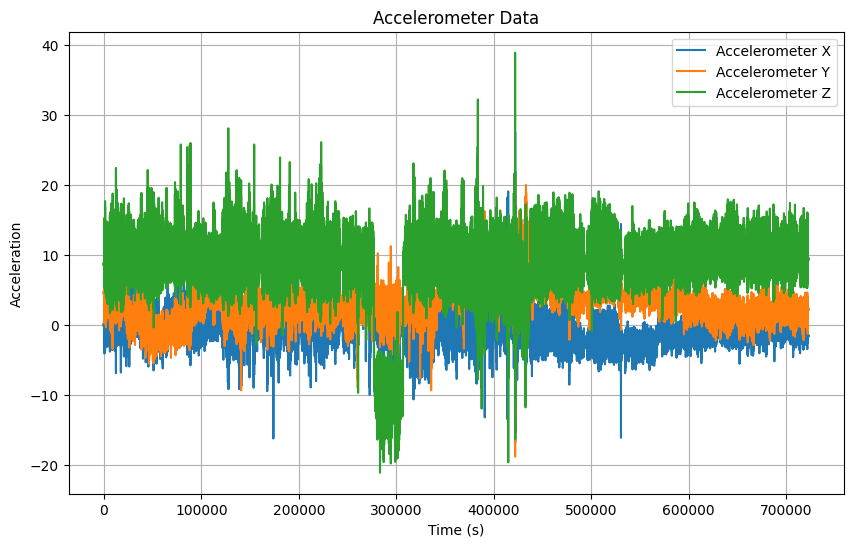

In [44]:
# Generate array of times
time = np.arange(0,722582)
# Plot accelerometer data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,0], label='Accelerometer X')
plt.plot(time, combined_df.iloc[:,1], label='Accelerometer Y')
plt.plot(time, combined_df.iloc[:,2], label='Accelerometer Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.title('Accelerometer Data')
plt.legend()
plt.grid(True)
plt.show()

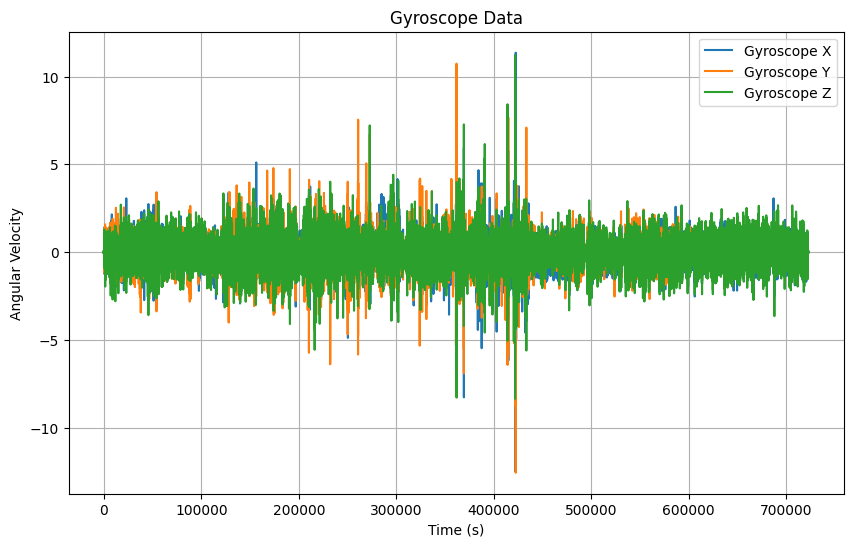

In [45]:
# Plot Gyroscope data
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(time, combined_df.iloc[:,3], label='Gyroscope X')
plt.plot(time, combined_df.iloc[:,4], label='Gyroscope Y')
plt.plot(time, combined_df.iloc[:,5], label='Gyroscope Z')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity')
plt.title('Gyroscope Data')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
class StepDetectionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features
        self.labels = self.data.iloc[:, 6].values  # Extract the labels

        self.label_mapping = {'No Label': 0, 'start': 1, 'end': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.label_mapping[self.labels[index]])

        return features, label


class StepDetectionTestDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.features = self.data.iloc[:, :6].values  # Extract the features

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        return features

python
    def __init__(self, dataframe):
        self.data = dataframe

The `__init__` method is the constructor for the class. It takes a dataframe as input and assigns it to the `self.data` attribute.

python
        self.features = self.data.iloc[:, :6].values

This line extracts the first 6 columns of the dataframe and assigns them to the `self.features` attribute. These columns are assumed to contain the features for each sample in the dataset.


python
        self.labels = self.data.iloc[:, 6].values

This line extracts the 7th column of the dataframe and assigns it to the `self.labels` attribute. This column is assumed to contain the labels for each sample in the dataset.


python
        self.label_mapping = {'No Label': 0, 'start': 1, 'end': 2}

This line defines a dictionary called `label_mapping` which maps label names to integer values. This will be used to convert the labels to numerical values for training.

python
    def __len__(self):
        return len(self.data)

The `__len__` method returns the length of the dataset, which is the number of samples in the dataframe.


python
    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.label_mapping[self.labels[index]])
        return features, label

The `__getitem__` method is used to retrieve an individual sample from the dataset. It takes an index as input and returns a tuple of features and labels for that index. The features are converted to torch tensors of type `float32`, and the labels are converted to their mapped integer values.



python
class StepDetectionTestDataset(Dataset):

This line defines a new class called `StepDetectionTestDataset` which extends the PyTorch `Dataset` class. This class will be used to create a dataset for test data.


python
    def __init__(self, dataframe):
        self.data = dataframe

The `__init__` method is the constructor for the class. It takes a dataframe as input and assigns it to the `self.data` attribute.

python
        self.features = self.data.iloc[:, :6].values

This line extracts the first 6 columns of the dataframe and assigns them to the `self.features` attribute. These columns are assumed to contain the features for each sample in the dataset.

python
    def __len__(self):
        return len(self.data)

The `__len__` method returns the length of the dataset, which is the number of samples in the dataframe.

python
    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        return features

The `__getitem__` method is used to retrieve an individual sample from the dataset. It takes an index as input and returns only the features for that index. The features are converted to a torch tensor of type `float32`.

In [32]:
# Create the train, validation, test dataset
dataset = StepDetectionDataset(combined_df)
test_dataset = StepDetectionTestDataset(test_df)
print(test_df.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

(102091, 6)


In [33]:
# Define the CNN model
class StepDetectionCNN(nn.Module):
    def __init__(self):
        super(StepDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=1, stride=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class StepDetectionCNN(nn.Module):

This line defines a new class called `StepDetectionCNN` which extends the PyTorch `nn.Module` class. This class will be used to define the CNN model for step detection.

python
    def __init__(self):
        super(StepDetectionCNN, self).__init__()

The `__init__` method is the constructor for the class. It calls the constructor of the parent class (`nn.Module`) using `super()` to initialize the model.

python
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=1, stride=1)

This line defines the first convolutional layer (`conv1`) of the CNN. It takes 1D input with 6 channels, applies 32 filters, each with a kernel size of 1, and a stride of 1.

python
        self.relu = nn.ReLU()

This line defines the ReLU activation function (`relu`), which will be applied after each convolutional layer.

python
        self.maxpool = nn.MaxPool1d(kernel_size=1)

This line defines the max pooling layer (`maxpool`) with a kernel size of 1. It will be used to downsample the feature maps after each convolutional layer.

python
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, stride=1)

This line defines the second convolutional layer (`conv2`) of the CNN. It takes 32 input channels (output from the previous convolutional layer), applies 64 filters, each with a kernel size of 1, and a stride of 1.

python
        self.fc = nn.Linear(64, 3)

This line defines the fully connected layer (`fc`) which will be used as the classifier. It takes input size 64 (output from the previous convolutional layer) and outputs a tensor of size 3, representing the three classes (No Label, start, end).

python
    def forward(self, x):

The `forward` method defines the forward pass of the model. It takes an input tensor `x` as input.

python
        x = x.unsqueeze(2)

This line adds an extra dimension to the input tensor `x` to match the expected shape of the convolutional layer. The tensor `x` will have a shape of [batch_size, channels, sequence_length].

python
        x = self.conv1(x)

This line applies the first convolutional layer (`conv1`) to the input tensor `x`.

python
        x = self.relu(x)

This line applies the ReLU activation function to the output of the first convolutional layer.

python
        x = self.maxpool(x)

This line applies the max pooling layer (`maxpool`) to the output of the first convolutional layer.

python
        x = self.conv2(x)

This line applies the second convolutional layer (`conv2`) to the output of the max pooling layer.

python
        x = self.relu(x)

This line applies the ReLU activation function to the output of the second convolutional layer.

python
        x = self.maxpool(x)

This line applies the max pooling layer (`maxpool`) to the output of the second convolutional layer.

python
        x = x.view(x.size(0), -1)

This line reshapes the tensor `x` to have a shape of [batch_size, num_features], where `num_features` is calculated based on the previous layers.

python
        x = self.fc(x)

This line applies the fully connected layer (`fc`) to the reshaped tensor `x`.

python
        return x

This line returns the output tensor `x`.

In this CNN model, the data is processed in the following steps:

1. The input tensor `x` is passed through the first convolutional layer (`conv1`). This layer applies a set of filters to the input tensor, extracting different features from the input data. The output of this layer will have a shape of [batch_size, out_channels, sequence_length], where `out_channels` is the number of filters applied and `sequence_length` is the length of the input sequence.

2. The output of the first convolutional layer is passed through the ReLU activation function (`relu`). ReLU applies an element-wise activation function, replacing negative values with zero and keeping positive values unchanged. This introduces non-linearity to the model and helps in capturing complex patterns in the data.

3. The output of the ReLU activation function is passed through the max pooling layer (`maxpool`). Max pooling is a downsampling operation that reduces the spatial dimensionality of the input. In this case, the kernel size is set to 1, so the output of the max pooling layer will have the same shape as the input.

4. The output of the max pooling layer is passed through the second convolutional layer (`conv2`). This layer applies another set of filters to the input tensor, extracting higher-level features from the previous layer's output.

5. The output of the second convolutional layer is passed through the ReLU activation function (`relu`).

6. The output of the ReLU activation function is passed through the max pooling layer (`maxpool`).

7. The output of the max pooling layer is reshaped using the `view` method. This operation flattens the tensor, collapsing all dimensions except the batch dimension. The resulting tensor will have a shape of [batch_size, num_features], where `num_features` is the product of the remaining dimensions.

8. The reshaped tensor is passed through the fully connected layer (`fc`). This layer performs a matrix multiplication between the input tensor and the weight matrix, followed by a bias addition. This step performs the classification task, mapping the extracted features to the output classes.

9. The final output tensor is returned from the `forward` method, representing the predicted class probabilities for each input sample.

the reasons mentioned for using a CNN model in this step detection problem are reflected in your CNN layer design. Let's go through each reason and see how it is incorporated in your CNN layer:

1. **Local feature extraction**: The convolutional layers (`conv1` and `conv2`) in your CNN are responsible for extracting local features from the input signals. By app+lying filters to the input data, these layers can capture important patterns and features that are relevant for step detection.

2. **Translation invariance**: The use of convolutional layers in your CNN allows for translation invariance. The filters applied in each convolutional layer can detect patterns regardless of their specific location in the signal, which is important for capturing the start and end of steps that can occur at different positions within the signals.

3. **Hierarchical feature representation**: Your CNN model has two convolutional layers (`conv1` and `conv2`) followed by a fully connected layer (`fc`). This architecture allows for the learning of hierarchical representations. The initial convolutional layers capture low-level features, while the subsequent layers can learn more complex and abstract features that contribute to the final step detection prediction.

4. **Efficient parameter sharing**: The use of convolutional layers in your CNN takes advantage of parameter sharing. The same weights are applied to different parts of the input signal, reducing the number of parameters and making the model more computationally efficient.


In [36]:
# Define the hyperparameters
hyperparameters = {
    'input_size': 6,
    'num_classes': 3,
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'num_layers': 6,
    'hidden_size': 256,
    'dropout': 0.5
}

In [37]:
# Initialize the CNN model with the hyperparameters
model = StepDetectionCNN()

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
num_epochs=hyperparameters['num_epochs']

In [38]:
# Training loop
for epoch in range(hyperparameters['num_epochs']):
    model.train()

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += (outputs.argmax(1) == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    predictions = []
    val_true_labels = []

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)
            val_true_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    val_losses.append(val_loss)

    # Print training and validation results for each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Calculate train accuracy
    model.eval()
    with torch.no_grad():
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(features)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

    train_accuracy = train_correct / train_total

    # Calculate test accuracy
    model.eval()
    with torch.no_grad():
        for features in test_loader:
            features = features.to(device)


            # Forward pass
            outputs = model(features)
            test_total += features.size(0)

    test_accuracy = test_correct / test_total

Epoch 1/10, Train Loss: 0.1624, Train Accuracy: 0.9644, Val Loss: 0.1571, Val Accuracy: 0.9645
Epoch 2/10, Train Loss: 0.1547, Train Accuracy: 0.9644, Val Loss: 0.1535, Val Accuracy: 0.9645
Epoch 3/10, Train Loss: 0.1524, Train Accuracy: 0.9644, Val Loss: 0.1527, Val Accuracy: 0.9645
Epoch 4/10, Train Loss: 0.1510, Train Accuracy: 0.9644, Val Loss: 0.1498, Val Accuracy: 0.9645
Epoch 5/10, Train Loss: 0.1503, Train Accuracy: 0.9644, Val Loss: 0.1525, Val Accuracy: 0.9645
Epoch 6/10, Train Loss: 0.1498, Train Accuracy: 0.9644, Val Loss: 0.1496, Val Accuracy: 0.9645
Epoch 7/10, Train Loss: 0.1495, Train Accuracy: 0.9644, Val Loss: 0.1487, Val Accuracy: 0.9645
Epoch 8/10, Train Loss: 0.1491, Train Accuracy: 0.9644, Val Loss: 0.1495, Val Accuracy: 0.9645
Epoch 9/10, Train Loss: 0.1490, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645
Epoch 10/10, Train Loss: 0.1488, Train Accuracy: 0.9644, Val Loss: 0.1486, Val Accuracy: 0.9645


python
for epoch in range(hyperparameters['num_epochs']):

This line starts a loop over the specified number of training epochs. The `hyperparameters['num_epochs']` value represents the total number of times the model will iterate over the entire training dataset.

python
    model.train()

This line sets the model to training mode, enabling features such as dropout and batch normalization to be applied during training.

python
    for features, labels in train_loader:

This line iterates over the training data loader, which provides batches of input features (`features`) and corresponding labels (`labels`) for each iteration.

python
        features = features.to(device)
        labels = labels.to(device)

These lines move the input features and labels to the device (e.g., GPU) specified in the `device` variable. This is done to ensure that the computations are performed on the specified device.

python
        optimizer.zero_grad()

This line clears the gradients of all optimized parameters. It is necessary to perform this step before computing the gradients for the current batch.

python
        outputs = model(features)
        loss = criterion(outputs, labels)

These lines perform a forward pass through the model to obtain the predicted outputs (`outputs`). The loss function (`criterion`) is then applied to compute the loss between the predicted outputs and the true labels.

python
        loss.backward()
        optimizer.step()

These lines perform the backward pass, where the gradients of the model's parameters are computed based on the computed loss. The optimizer then updates the model's parameters using the gradients.

python
        train_loss += loss.item()
        train_accuracy += (outputs.argmax(1) == labels).sum().item()

These lines accumulate the training loss and accuracy values for each epoch. The training loss (`loss.item()`) is added to the `train_loss` variable, while the number of correctly predicted labels is summed up to calculate the training accuracy.

python
    train_loss /= len(train_loader)
    train_accuracy /= len(train_dataset)
    train_losses.append(train_loss)

These lines calculate the average training loss and accuracy for the current epoch by dividing the accumulated values by the number of batches in the training loader (`len(train_loader)`) and the total number of samples in the training dataset (`len(train_dataset)`), respectively. The computed values are then appended to the `train_losses` list.

python
    model.eval()

This line sets the model to evaluation mode, disabling features such as dropout and batch normalization to ensure consistent and deterministic predictions during validation.

python
    val_loss = 0.0
    val_accuracy = 0.0
    predictions = []
    val_true_labels = []

These lines initialize variables to accumulate the validation loss, accuracy, predicted probabilities (`predictions`), and true labels (`val_true_labels`) for each epoch.

python
    with torch.no_grad():
        for features, labels in val_loader:

This line starts a loop over the validation data loader, which provides batches of input features (`features`) and corresponding labels (`labels`) for each iteration. The `torch.no_grad()` context ensures that no gradients are computed during this loop to save memory.

python
            features = features.to(device)
            labels = labels.to(device)

These lines move the input features and labels to the specified device (e.g., GPU) for consistent computations.

python
            outputs = model(features)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)
            val_true_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)

These lines perform a forward pass through the model to obtain the predicted outputs (`outputs`). The probabilities are calculated by applying softmax to the outputs. The predicted probabilities and true labels are stored in the `predictions` and `val_true_labels` lists, respectively. The loss between the predicted outputs and true labels is computed using the loss function.

python
            val_loss += loss.item()
            val_accuracy += (outputs.argmax(1) == labels).sum().item()

These lines accumulate the validation loss and accuracy values for each epoch, similar to what was done for training.

python
    val_loss /= len(val_loader)
    val_accuracy /= len(val_dataset)
    val_losses.append(val_loss)

These lines calculate the average validation loss and accuracy for the current epoch by dividing the accumulated values by the number of batches in the validation loader (`len(val_loader)`) and the total number of samples in the validation dataset (`len(val_dataset)`), respectively. The computed values are then appended to the `val_losses` list.

python
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

This line prints the training and validation loss, as well as the training and validation accuracy for the current epoch.

python
    model.eval()

This line sets the model to evaluation mode before calculating the final training accuracy.

python
    with torch.no_grad():
        for features, labels in train_loader:

This line starts a loop over the training data loader to calculate the final training accuracy. Similar to the validation loop, the `torch.no_grad()` context ensures that no gradients are computed during this loop.

python
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

These lines accumulate the number of correctly predicted labels (`train_correct`) and the total number of labels (`train_total`) for each batch in the training loop.

python
    train_accuracy = train_correct / train_total

This line calculates the final training accuracy by dividing the number of correctly predicted labels by the total number of labels.

python
    with torch.no_grad():
        for features in test_loader:

This line starts a loop over the test data loader to calculate the final test accuracy. Again, the `torch.no_grad()` context ensures that no gradients are computed during this loop.

python
        test_total += features.size(0)

This line accumulates the total number of samples in the test dataset.

python
    test_accuracy = test_correct / test_total

This line calculates the final test accuracy by dividing the number of correctly predicted labels (`test_correct`) by the total number of samples in the test dataset (`test_total`).


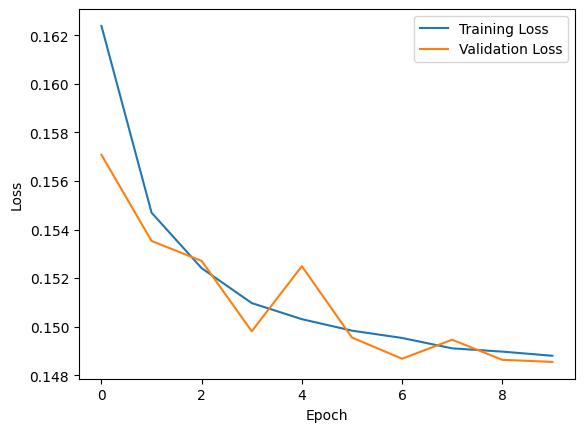

In [41]:
# Plotting the training loss vs. validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
#Output.csv Generation
def test(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            predictions.extend(probabilities)

    return predictions

def write_output_file(file_path, predictions):
    with open(file_path, 'w') as file:
        file.write('index,start,end\n')
        for time_point, pred in enumerate(predictions):
            start_prob = pred[1]  # Probability of being the start of a step
            end_prob = pred[2]  # Probability of being the end of a step

            line = f'{time_point},{start_prob:.6f},{end_prob:.6f}\n'
            file.write(line)

output_file = '/content/sample_data/step_predictions_CNN128_.csv'
test_predictions = test(model, test_loader,device)
write_output_file(output_file,test_predictions)

- This is a function named `test` that takes in the `model`, `dataloader`, and `device` as parameters.
- `model.eval()` sets the model to evaluation mode, disabling features such as dropout and batch normalization.
- An empty list named `predictions` is initialized to store the predicted probabilities.
- The `torch.no_grad()` context ensures that no gradients are computed during the evaluation loop to save memory.
- The loop iterates over the `dataloader`, which provides inputs (`inputs`) for each iteration.
- `inputs` are moved to the specified `device` (e.g., GPU) for consistent computations.
- The inputs are passed through the model (`model(inputs)`) to obtain the predicted outputs (`outputs`).
- `torch.softmax(outputs, dim=1)` applies softmax to the outputs along the second dimension (class probabilities).
- `cpu().numpy()` moves the probabilities to the CPU and converts them to a NumPy array.
- The probabilities are then extended to the `predictions` list.
- Finally, the `predictions` list is returned.

- This is a function named `write_output_file` that takes in the `file_path` and `predictions` as parameters.
- The function opens the specified `file_path` in write mode using `open(file_path, 'w')`.
- `'index,start,end\n'` is written as the header line in the file using `file.write('index,start,end\n')`.
- The function then loops over the `predictions` list using `enumerate(predictions)`, which provides the `time_point` and corresponding `pred` at each iteration.
- `start_prob` is assigned to `pred[1]`, representing the probability of being the start of a step.
- `end_prob` is assigned to `pred[2]`, representing the probability of being the end of a step.
- `line` is formatted as a string using `f'{time_point},{start_prob:.6f},{end_prob:.6f}\n'`, where `:.6f` ensures that the probabilities are formatted with 6 decimal places.
- `line` is then written to the file using `file.write(line)`.


- `output_file` is a variable that stores the path and name of the output file where the predictions will be written.
- `test_predictions` is a variable that stores the predictions obtained by calling the `test` function with the `model`, `test_loader`, and `device`.
- The `write_output_file` function is called with the `output_file` and `test_predictions` as arguments to write the predictions to the output file.

Adam: Adam stands for "Adaptive Moment Estimation" and is an extension of SGD that combines the benefits of both adaptive learning rates and momentum. It adapts the learning rate for each parameter based on the estimates of the first and second moments of the gradients.


Dropout is a regularization technique commonly used in deep learning models to prevent overfitting. It helps to improve the generalization and performance of the model by reducing the co-adaptation of neurons during training.

During the training process, dropout randomly sets a fraction of input units (neurons) to zero at each update, effectively "dropping out" those units. This means that these units and their connections are ignored during forward and backward propagation.